In [1]:
import torch
import sys
import os
import json
import time
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

sys.path.append("..")
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.vis_models import vis_models as vmodels
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructor
from singleVis.projector import DVIProjector
from singleVis.eval.evaluator import Evaluator

/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/

In [2]:
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "tDVI" # DeepVisualInsight

In [3]:
CONTENT_PATH ="/home/xianglin/projects/DVI_data/resnet18_fmnist"
I = 25
GPU_ID = "0"

In [4]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [5]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]
EPOCH_NAME = config["EPOCH_NAME"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
VIS_MODEL = VISUALIZATION_PARAMETER['VIS_MODEL']
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]
VIS_MODEL_NAME = f"{VIS_MODEL_NAME}_intrinsic"
EVALUATION_NAME = f"{EVALUATION_NAME}_intrinsic"

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

In [6]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, epoch_name="Epoch", device=DEVICE, classes=CLASSES,verbose=1)
if PREPROCESS:
    data_provider._meta_data()
    if B_N_EPOCHS >0:
        data_provider._estimate_boundary(LEN//10, l_bound=L_BOUND)

Finish initialization...


In [7]:
from singleVis.intrinsic_dim import IntrinsicDim
ID = IntrinsicDim(data_provider.train_representation(I))
dimension = ID.estimate_id_fast()
dimension

10.597407

In [8]:
ENCODER_DIMS = [512,256,128, 100]
DECODER_DIMS = [100, 128, 256, 512]
model = vmodels["bnAE"](ENCODER_DIMS, DECODER_DIMS)

In [9]:
# save_dir = os.path.join(data_provider.model_path, f"{EPOCH_NAME}_{I}")
# # optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
# trainer = SingleVisTrainer(model, None, None, None,edge_loader=None, DEVICE=DEVICE)
# projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
# trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))
# # embedded = projector.batch_project(I, data_provider.train_representation(I))
# evaluator = Evaluator(data_provider, projector)
# evaluator.eval_nn_train(I, 15)

In [10]:
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)

# Define DVI Loss
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA)

# Define training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)

In [11]:
# Define Edge dataset
t0 = time.time()
spatial_cons = SingleEpochSpatialEdgeConstructor(data_provider, I, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, metric="euclidean")
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
t1 = time.time()

Sun Sep  3 10:36:36 2023 Building RP forest with 17 trees
Sun Sep  3 10:36:38 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [12]:
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>1e-2#1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]

dataset = DataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=1000, sampler=sampler)

In [13]:
trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler,edge_loader=edge_loader, DEVICE=DEVICE)

t2=time.time()
trainer.train(PATIENT, MAX_EPOCH)
t3 = time.time()

epoch:1


100%|██████████| 756/756 [00:16<00:00, 44.76it/s]


umap:0.0639	recon:0.0057	loss:0.0696
epoch:2


100%|██████████| 756/756 [00:17<00:00, 44.43it/s]


umap:0.0624	recon:0.0028	loss:0.0653
epoch:3


100%|██████████| 756/756 [00:18<00:00, 41.65it/s]


umap:0.0621	recon:0.0027	loss:0.0647
epoch:4


100%|██████████| 756/756 [00:18<00:00, 40.05it/s]


umap:0.0615	recon:0.0026	loss:0.0641
epoch:5


100%|██████████| 756/756 [00:17<00:00, 43.21it/s]

umap:0.0596	recon:0.0018	loss:0.0614
Time spend: 89.71 for training vis model...


In [14]:
save_dir = os.path.join(data_provider.model_path, f"{EPOCH_NAME}_{I}")
trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

Successfully save visualization model...


In [15]:
evaluator = Evaluator(data_provider, projector, metric="euclidean")
evaluator.eval_nn_train(I, 15)

Sun Sep  3 10:38:15 2023 Building RP forest with 17 trees
Sun Sep  3 10:38:16 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Sep  3 10:38:18 2023 Building RP forest with 17 trees
Sun Sep  3 10:38:18 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 4.77/15 in epoch 25


4.773316666666667

In [16]:
train_repr = data_provider.train_representation(I)
train_data = projector.batch_project(I, train_repr)

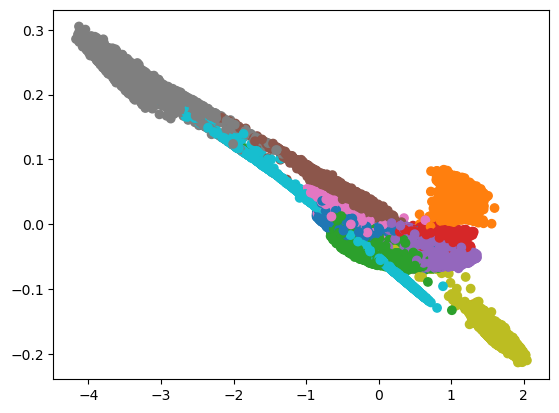

In [17]:
import matplotlib.pyplot as plt
mesh_classes = np.arange(10)
color = plt.get_cmap("tab10")(mesh_classes / 9)
color = color[:, 0:3]
labels = data_provider.train_labels(I)
labels_color = color[labels]
plt.scatter(train_data[:, 0], train_data[:, 1],c=labels_color)
plt.show()

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedded = pca.fit_transform(train_data)

In [27]:
pca.singular_values_

array([4767.109, 1226.513], dtype=float32)

In [28]:
from singleVis.eval.evaluate import evaluate_proj_nn_perseverance_knn
val = evaluate_proj_nn_perseverance_knn(train_repr, embedded, n_neighbors=15, metric="euclidean")
val


Sun Sep  3 10:40:25 2023 Building RP forest with 17 trees
Sun Sep  3 10:40:26 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sun Sep  3 10:40:28 2023 Building RP forest with 17 trees
Sun Sep  3 10:40:28 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations


2.353083333333333

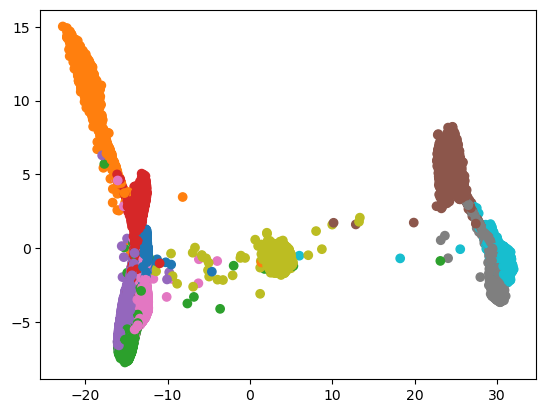

In [25]:
import matplotlib.pyplot as plt
plt.scatter(embedded[:, 0], embedded[:, 1],c=labels_color)
plt.show()